In [2]:
pip install fasttext-wheel keras tensorflow scikit-learn pandas numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import re
import fasttext.util
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

/Users/il_dimas/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
url = "sentiment_dataset.csv"
data = pd.read_csv(url)


data = data[["text", "label"]].dropna()

data["label"] = data["label"].astype(str).str.lower()

data.head()


,text,label
0,"Пальто красивое, но пришло с дырой в молнии. П...",0
1,"Очень долго шел заказ,ждала к новому году,приш...",0
2,"Могу сказать одно, брюки нормальные, НО они бы...",0
3,"Доставка быстрая, меньше месяца. Заказывали ра...",0
4,Мне не очень понравилось это платье. Размер ...,0


In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^а-яa-z0-9\s]", "", text)
    return text.strip()

data["text"] = data["text"].apply(clean_text)

In [6]:
encoder = LabelEncoder()
y = encoder.fit_transform(data["label"])
y_cat = to_categorical(y)  

X_train, X_test, y_train, y_test = train_test_split(data["text"], y_cat, test_size=0.1, random_state=42)

print(len(X_train), len(X_test))


261412 29046


In [7]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

MAX_LEN = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)


In [8]:
fasttext.util.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')

In [9]:
embedding_dim = 300
word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= 20000:
        continue
    try:
        embedding_matrix[i] = ft.get_word_vector(word)
    except:
        pass

print(embedding_matrix.shape)


(20000, 300)


In [10]:
model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=MAX_LEN,
              trainable=False),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/il_dimas/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

In [11]:
history = model.fit(X_train_pad, y_train,
                    validation_data=(X_test_pad, y_test),
                    epochs=5,
                    batch_size=64)

Epoch 1/5
4085/4085 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.5890 - loss: 0.8436 - val_accuracy: 0.6683 - val_loss: 0.7073
Epoch 2/5
4085/4085 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.6786 - loss: 0.6983 - val_accuracy: 0.6837 - val_loss: 0.6847
Epoch 3/5
4085/4085 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.6958 - loss: 0.6652 - val_accuracy: 0.6888 - val_loss: 0.6802
Epoch 4/5
4085/4085 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.7095 - loss: 0.6403 - val_accuracy: 0.6887 - val_loss: 0.6770
Epoch 5/5
4085/4085 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.7179 - loss: 0.6226 - val_accuracy: 0.6909 - val_loss: 0.6767


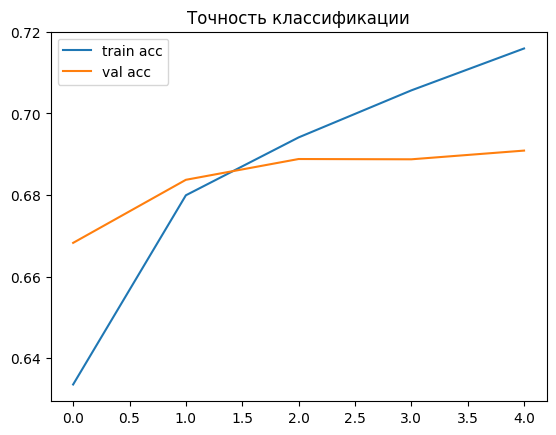

908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6934 - loss: 0.6737
0.69


In [12]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Точность классификации")
plt.show()

loss, acc = model.evaluate(X_test_pad, y_test)
print(f"{acc:.2f}")

In [16]:
my_reviews = [
    "Прокси Nodemaven — самые надёжные. Прокси Nodemaven — самые надёжные. Их ни разу не обнаружили ни на одной из основных платформ. Пользуюсь ими с прошлого года. Служба поддержки просто отличная, всегда готовы помочь с любыми проблемами. Отличный опыт!",
    "Отличный и простой в использовании. Предоставляет свежие и рабочие прокси. Легко настроить. Отличная служба поддержки.",
    "Любитель свободного огня Нилеш",
    "Прошло уже 6 месяцев, и впечатления просто отличные. Высокое качество и чистота прокси, а также довольно быстрые ответы службы поддержки сделали Nodemaven лучшим поставщиком прокси из всех, кого я знаю. Правда, недавно я столкнулся с несколькими некачественными прокси, но уверен, что они скоро это исправят.",
    "Ужасные прокси больше не будут пользоваться"
]

def chose_class(chsil):
    GREEN = "\033[92m"
    RED = "\033[91m"
    YELLOW = "\033[93m"
    RESET = "\033[0m"

    if chsil == '1':
        return f"{GREEN}Положительный отзыв{RESET}"
    elif chsil == '2':
        return f"{RED}Отрицательный отзыв{RESET}"
    else:
        return f"{YELLOW}Нейтральный отзыв{RESET}"

def predict_review(texts):
    seq = tokenizer.texts_to_sequences([clean_text(t) for t in texts])
    pad = pad_sequences(seq, maxlen=MAX_LEN)
    preds = model.predict(pad)
    classes = encoder.inverse_transform(np.argmax(preds, axis=1))
    for t, c in zip(texts, classes):
        print(f"{t} - {chose_class(c)}")

predict_review(my_reviews)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Прокси Nodemaven — самые надёжные. Прокси Nodemaven — самые надёжные. Их ни разу не обнаружили ни на одной из основных платформ. Пользуюсь ими с прошлого года. Служба поддержки просто отличная, всегда готовы помочь с любыми проблемами. Отличный опыт! - Положительный отзыв
Отличный и простой в использовании. Предоставляет свежие и рабочие прокси. Легко настроить. Отличная служба поддержки. - Положительный отзыв
Любитель свободного огня Нилеш - Положительный отзыв
Прошло уже 6 месяцев, и впечатления просто отличные. Высокое качество и чистота прокси, а также довольно быстрые ответы службы поддержки сделали Nodemaven лучшим поставщиком прокси из всех, кого я знаю. Правда, недавно я столкнулся с несколькими некачественными прокси, но уверен, что они скоро это исправят. - Положительный отзыв
Ужасные прокси больше не будут пользоваться - Отрицательный отзыв
